In [1]:
import json
with open('models/model_subscriptions.json','r') as f:
    models_info = json.load(f)

In [2]:
import os

# Arrange GPU devices starting from 0
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # Set the GPUs 2 and 3 to use

In [3]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'ch3_32_interval_3_240'
_model = torch.load(os.path.join('models', model_name, f"{model_name}.pth"))
_model = _model.to(device)
model = nn.DataParallel(_model).to(device)
model.eval()
model_info = next((model for model in models_info if model['model_name'] == model_name), None)
print(model_info)

{'model_name': 'ch3_32_interval_3_240', 'depth / in_channel / n_channel': [52, 3, 32], 'img_size': 240, 'used_channel': ['-t1n.nii.gz', '-t1c.nii.gz', '-t2f.nii.gz'], 'val score(dice/jaccard)': [88, 81], 'batch/total epoch/best epoch': [1, 50, 33], 'resize_info': [0, 155, 3], 'run time(m)': 1360.0}


In [4]:
from utils import get_dataloader,preprocess_mask_labels
from dataset import BratsDataset
import os
import nibabel as nib
import numpy as np
val_dataloader = get_dataloader(dataset=BratsDataset, phase="test", resize_info=model_info['resize_info'], img_width=model_info['img_size'], data_type=model_info['used_channel'])
# val_dataloader = get_dataloader(dataset=BratsDataset, phase="val", resize_info=[2,152,3])

test_batch = next(iter(val_dataloader))
batch_id, images, targets = test_batch['Id'], test_batch['image'], test_batch['mask']
images = images.to(device)
targets = targets.to(device)
print('batch id',batch_id)
print('loaded image, target shape',images.shape, targets.shape)
targets = targets[0]
targets = targets.detach().cpu().numpy()

batch id ['BraTS-GLI-00054-000', 'BraTS-GLI-01477-000', 'BraTS-GLI-01022-000', 'BraTS-GLI-01104-000']
loaded image, target shape torch.Size([4, 3, 52, 240, 240]) torch.Size([4, 3, 155, 240, 240])


In [5]:
targets.shape

(3, 155, 240, 240)

In [6]:
from skimage.transform import resize

with torch.no_grad():
    logits = model(images[0].unsqueeze(0))
    pred = torch.sigmoid(logits).detach().cpu().numpy()
    threshold = 0.33
    pred = (pred >= threshold).astype(int)
    print("min/max:",pred.min(),'/', pred.max(), ', predicttion shape:',pred.shape)
pred = pred[0] # first of batches
resized_pred = resize(pred,(3,155,240,240), preserve_range=True) #(3,155,240,240)
print('before: ',pred.shape, 'after:',resized_pred.shape)

min/max: 0 / 1 , predicttion shape: (1, 3, 52, 240, 240)
before:  (3, 52, 240, 240) after: (3, 155, 240, 240)


In [7]:
mask_set = {
    "WT": targets[0],
    "TC": targets[1],
    "ET": targets[2],
}
pred_set = {
    "WT": pred[0],
    "TC": pred[1],
    "ET": pred[2],
}
ori_mask_set = {
    "WT": targets[0],
    "TC": targets[1],
    "ET": targets[2],
}
ori_pred_set = {
    "WT": resized_pred[0],
    "TC": resized_pred[1],
    "ET": resized_pred[2],
}
print(mask_set["WT"].shape,pred_set["WT"].shape,ori_mask_set["WT"].shape,ori_pred_set["WT"].shape)

(155, 240, 240) (52, 240, 240) (155, 240, 240) (155, 240, 240)


In [8]:
import matplotlib.pyplot as plt
def comp_gt_pred(percent, slices, gt, pred):
    slide2show = int(percent/100*slices)
    print(slide2show)
    plt.suptitle(f"Compare at slice {slide2show}/{slices}({percent}%)")
    for i,clas in enumerate(gt):
        plt.subplot(2,3,i+1)
        plt.title(f'GT of {clas}')
        plt.imshow(gt[clas][slide2show], cmap='gray')
        plt.axis('off')
        plt.subplot(2,3,i+1+3)
        plt.title(f'prediction of {clas}')
        plt.axis('off')
        plt.imshow(pred[clas][slide2show], cmap='gray')
    plt.show()

23


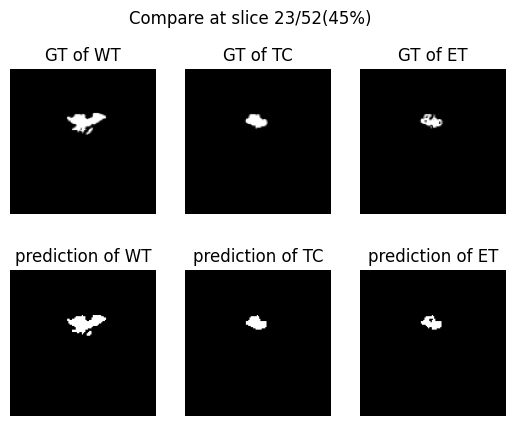

23


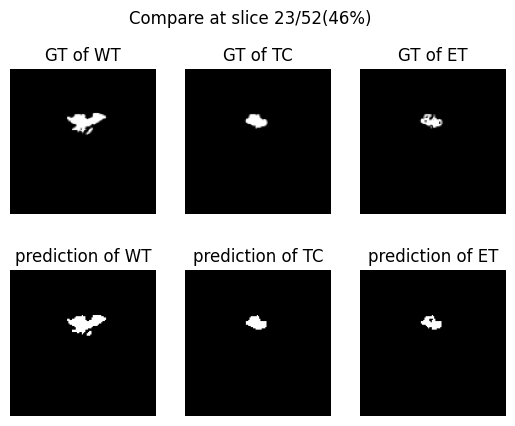

24


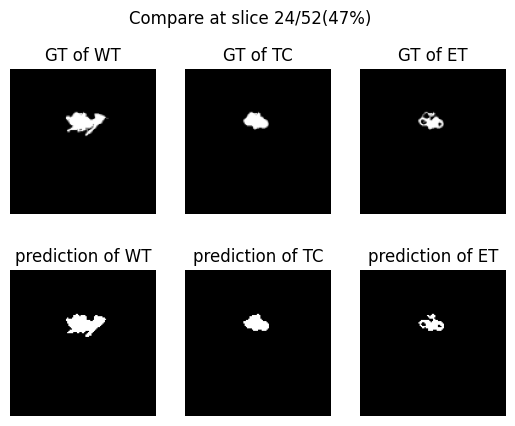

24


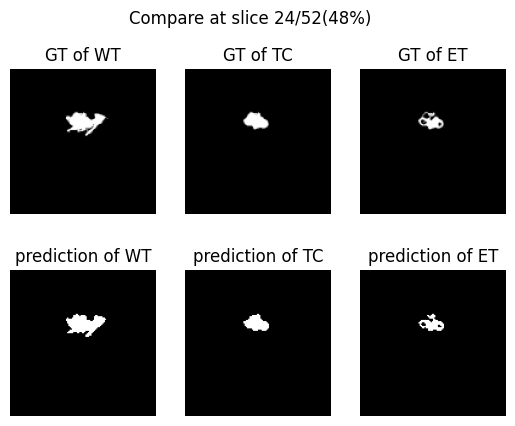

25


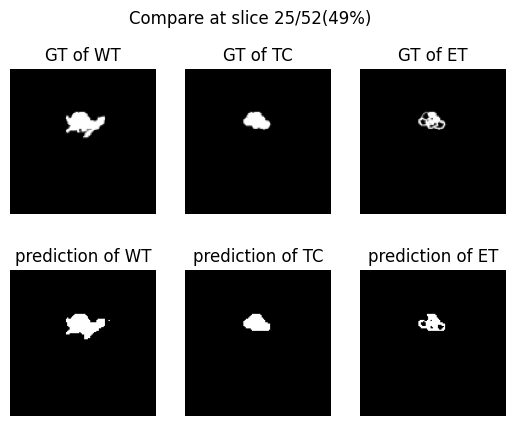

26


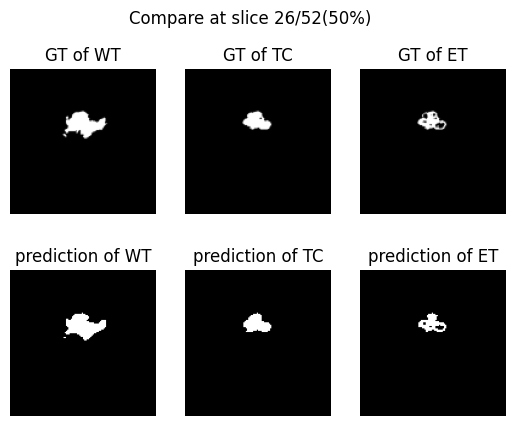

26


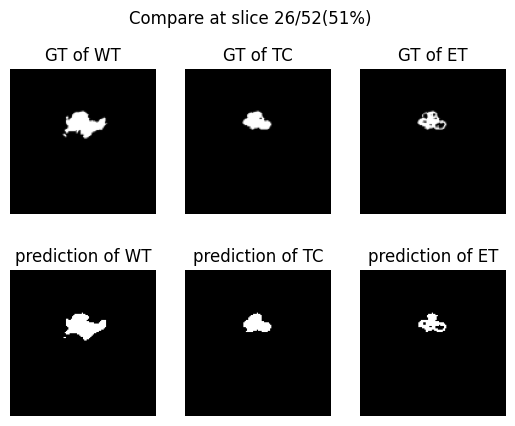

27


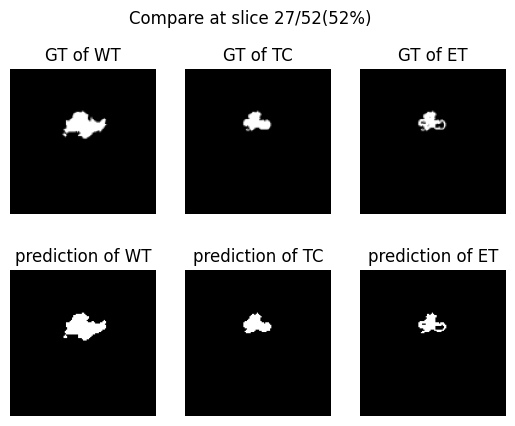

27


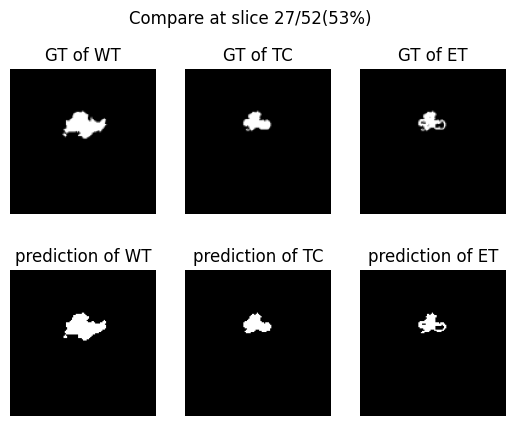

28


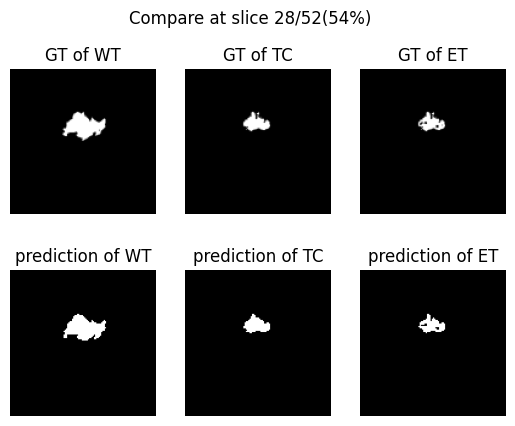

In [7]:
for percent in range(45,55):
    comp_gt_pred(percent,model_info['resized_depth'], mask_set, pred_set)

77


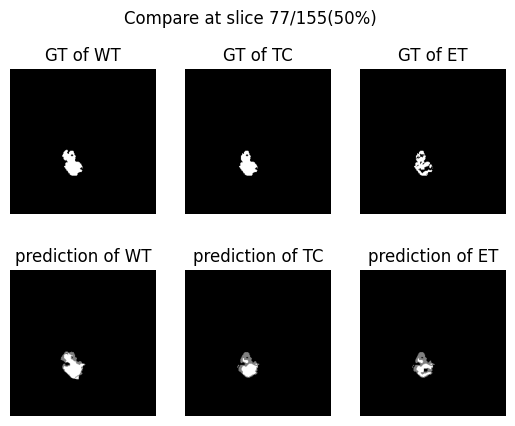

85


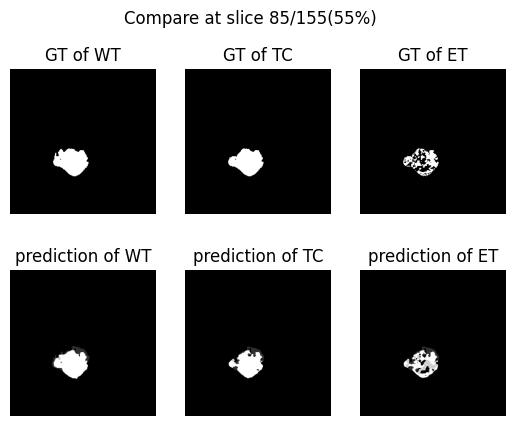

93


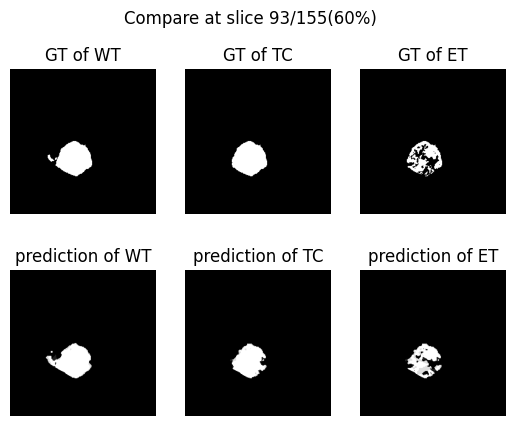

100


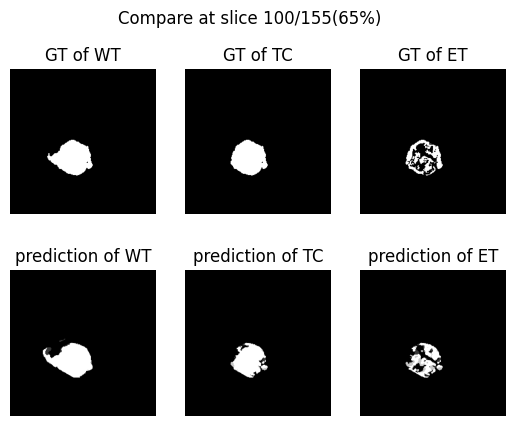

In [9]:
for percent in range(50,70,5):
    comp_gt_pred(percent,155, ori_mask_set, ori_pred_set)

In [9]:
from eval_utils import compute_dice
def slice_per_dice(slice2show):
    score_dict = {'inverval-3':{},'original':{}}
    for clas in mask_set:
        score = compute_dice(mask_set[clas][slice2show], pred_set[clas][slice2show])
        score_dict['inverval-3'][clas] = score
        ori_score = compute_dice(ori_mask_set[clas][slice2show*3+2], ori_pred_set[clas][slice2show*3+2])
        score_dict['original'][clas] = ori_score
    print(slice2show, score_dict)

In [10]:
for i in range(20,30):
    slice_per_dice(i)

20 {'inverval-3': {'WT': 0.3157894736842105, 'TC': 1.0, 'ET': 1.0}, 'original': {'WT': 0.630192502532928, 'TC': 0.0, 'ET': 0.0}}
21 {'inverval-3': {'WT': 0.6997084548104956, 'TC': 0.48484848484848486, 'ET': 0.48484848484848486}, 'original': {'WT': 0.7423167848699763, 'TC': 0.6625386996904025, 'ET': 0.6562009419152276}}
22 {'inverval-3': {'WT': 0.7601476014760148, 'TC': 0.7312775330396476, 'ET': 0.7256637168141593}, 'original': {'WT': 0.7953410981697171, 'TC': 0.8078725398313027, 'ET': 0.7336065573770492}}
23 {'inverval-3': {'WT': 0.7791842475386779, 'TC': 0.7610619469026548, 'ET': 0.7116564417177914}, 'original': {'WT': 0.8278823918070697, 'TC': 0.8517587939698492, 'ET': 0.7341772151898734}}
24 {'inverval-3': {'WT': 0.8067796610169492, 'TC': 0.7941176470588235, 'ET': 0.6880733944954128}, 'original': {'WT': 0.8414669361825007, 'TC': 0.8926315789473684, 'ET': 0.7754846779237023}}
25 {'inverval-3': {'WT': 0.8354166666666667, 'TC': 0.828996282527881, 'ET': 0.7142857142857143}, 'original': 

In [11]:
print('WT',compute_dice(mask_set['WT'],pred_set['WT']))
print('TC',compute_dice(mask_set['TC'],pred_set['TC']))
print('ET',compute_dice(mask_set['ET'],pred_set['ET']))

WT 0.8241133969444597
TC 0.7880807684767692
ET 0.7187045879177911


In [12]:
print('WT',compute_dice(ori_mask_set['WT'],ori_pred_set['WT']))
print('TC',compute_dice(ori_mask_set['TC'],ori_pred_set['TC']))
print('ET',compute_dice(ori_mask_set['ET'],ori_pred_set['ET']))

WT 0.8541399514687604
TC 0.8154260279033761
ET 0.7547853576729572


In [13]:
wt_score = compute_dice(ori_mask_set['WT'],ori_pred_set['WT'])
tc_score = compute_dice(ori_mask_set['TC'],ori_pred_set['TC'])
et_score = compute_dice(ori_mask_set['ET'],ori_pred_set['ET'])

print(f'Dice Score WT/TC/ET: {wt_score:.3f}/{tc_score:.3f}/{et_score:.3f}')

Dice Score WT/TC/ET: 0.854/0.815/0.755


In [14]:
total_mask = np.stack([ori_mask_set['WT'], ori_mask_set['TC'],ori_mask_set['ET']])
total_pred = np.stack([ori_pred_set['WT'], ori_pred_set['TC'],ori_pred_set['ET']])
total_mask.shape, total_pred.shape

((3, 155, 240, 240), (3, 155, 240, 240))

In [15]:
compute_dice(total_mask, total_pred)

0.8305273026146812